In [1]:
#installing required packages
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install rouge-score

  Using cached xxhash-3.5.0-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
Using cached multiprocess-0.70.16-py312-none-any.whl (146 kB)
Using cached xxhash-3.5.0-cp312-cp312-win_amd64.whl (30 kB)
  Using cached rouge_score-0.1.2-py3-none-any.whl


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
from tqdm import tqdm
from rouge_score import rouge_scorer

# #importing the data from google drive
# from google.colab import drive
# drive.mount('/content/drive')

RuntimeError: Failed to import transformers.optimization_tf because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [3]:


#creating pandas dataframe using the data
data = pd.read_csv('/kaggle/input/datta-set-2/news_summary.csv',encoding="latin-1")
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


* Here ctext column is the news (the text which we want to summarize).
* Text column is the summary for the respective text.
* i will be using only these two columns for further exploration and modelling.

In [4]:
#selecting only text and ctext columns
data = data[['text','ctext']]
data.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [5]:
#renaming the columns
data.rename(columns={'text':"summary",'ctext':'text'},inplace=True)

## **EDA**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  4514 non-null   object
 1   text     4396 non-null   object
dtypes: object(2)
memory usage: 70.7+ KB


In [7]:
print("Number of rows in the data:",data.shape[0])

Number of rows in the data: 4514


In [8]:
#checking the data for missing values
data.isna().sum()

summary      0
text       118
dtype: int64

* There are 118 missing values in the text column
* Dropping the rows with null values in text column will be a better idea

In [9]:
#dropping data with missing values
data.dropna(inplace=True)
#dropping duplicates if any in the data
data.drop_duplicates(inplace=True)

In [10]:
print("Number of rows in the data after removing duplicates and missing rows:",data.shape[0])

Number of rows in the data after removing duplicates and missing rows: 4396


In [11]:
#function to remove numbers and punctuations in the data
#removing numbers and punctuations to get exact number of words in the data
def clean_text(text):
  text = text.lower()
  text = re.sub(pattern=r"[^a-zA-Z0-9_\s]",repl="",string=text)
  text = re.sub(pattern=r" {2,10}",repl=" ",string=text)
  return text

In [12]:
cleaned_data=pd.DataFrame()
cleaned_data['text'] = data['text'].apply(clean_text)
cleaned_data['summary'] = data['summary'].apply(clean_text)

summary_lengths=[len(summary.split()) for summary in cleaned_data['summary']]
text_lengths=[len(text.split()) for text in cleaned_data['text']]

Text(0.5, 0.98, 'Distribution of words in summary and original text')

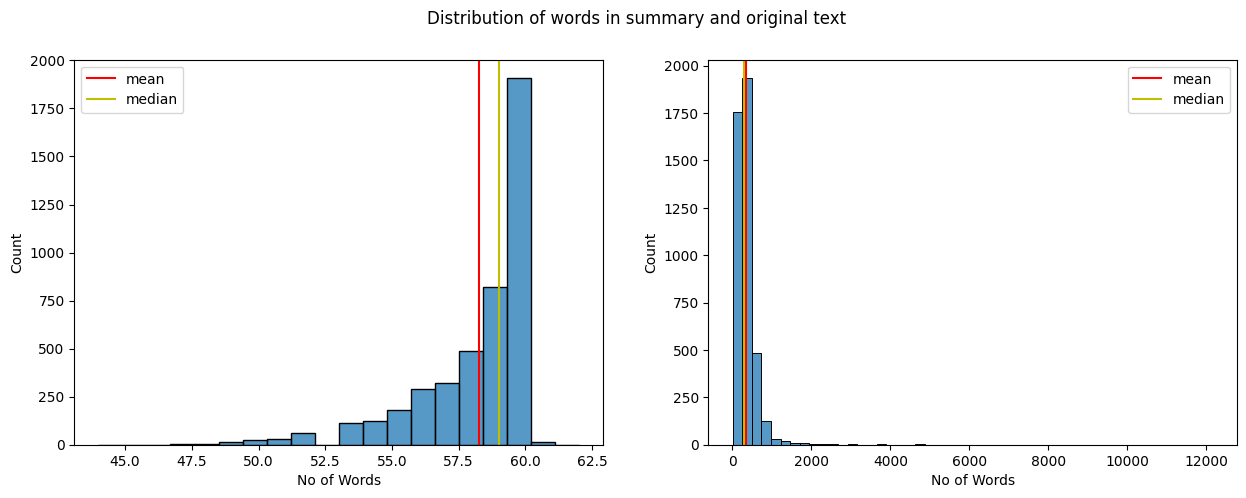

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(summary_lengths,bins=20)
plt.axvline(np.mean(summary_lengths),color="r",label="mean")
plt.axvline(np.median(summary_lengths),color="y",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.subplot(1,2,2)
sns.histplot(text_lengths,bins=50)
plt.axvline(np.mean(text_lengths),color="r",label="mean")
plt.axvline(np.median(text_lengths),color="y",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.suptitle("Distribution of words in summary and original text")

In [14]:
print("Average number of words in the summary are:",np.median(summary_lengths))
print("Average number of words in the complete text are:",np.median(text_lengths))

Average number of words in the summary are: 59.0
Average number of words in the complete text are: 282.0


In [15]:
#adding summarize: as prefix for the input sequence
#because the T5 model has been pretrained in the similar fashion for summarization tasks
data['text']=data['text'].apply(lambda x:"summarize: "+x)
data.head(5)

,summary,text
0,The Administration of Union Territory Daman an...,summarize: The Daman and Diu administration on...
1,Malaika Arora slammed an Instagram user who tr...,summarize: From her special numbers to TV?appe...
2,The Indira Gandhi Institute of Medical Science...,summarize: The Indira Gandhi Institute of Medi...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,summarize: Lashkar-e-Taiba's Kashmir commander...
4,Hotels in Maharashtra will train their staff t...,summarize: Hotels in Mumbai and other Indian c...


In [16]:
#splitting the data into train and validation split in the ratio (85:15)
split = int(len(data)/100*85)
training_data = data[:split]
valid_data = data[split:]

#saving the training and validation split into CSV
training_data.to_csv("news_summarization_training.csv")
valid_data.to_csv("news_summarization_validation.csv")

In [17]:
#importing the dataset into huggingface dataset format for efficient handling and training
train_data = pd.read_csv("news_summarization_training.csv",index_col=None)
valid_data = pd.read_csv("news_summarization_validation.csv",index_col=None)
train = Dataset.from_pandas(train_data)
valid = Dataset.from_pandas(valid_data)
dataset=DatasetDict()
dataset['training']=train.remove_columns(['Unnamed: 0'])
dataset['validation']=valid.remove_columns(['Unnamed: 0'])
dataset

DatasetDict({
    training: Dataset({
        features: ['summary', 'text'],
        num_rows: 3736
    })
    validation: Dataset({
        features: ['summary', 'text'],
        num_rows: 660
    })
})

In [18]:
#defining the maximum sequence length for input and target
max_input_length=512
max_target_length=128

#creating a function to preprocess (convert tokens into ids) the input and target sequences
def preprocess(data):
  inputs = tokenizer(data['text'],
                     max_length=max_input_length,
                     truncation=True)
  with tokenizer.as_target_tokenizer():
    labels=tokenizer(data['summary'],
                     max_length=max_target_length,
                     truncation=True)
  inputs['labels']=labels['input_ids']
  return inputs

In [19]:
#using t5-base model for model building
model_checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [20]:
#applying the preprocess unction on the dataset
tokenized_dataset = dataset.map(preprocess,batched=True)

Map:   0%|          | 0/3736 [00:00<?, ? examples/s]

Map:   0%|          | 0/660 [00:00<?, ? examples/s]

In [21]:
tokenized_dataset

DatasetDict({
    training: Dataset({
        features: ['summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3736
    })
    validation: Dataset({
        features: ['summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 660
    })
})

* The input sequences are converted into input_ids, attention_mask.
* The target is converted into target labels(target_input_ids).
* Removing the original text and summary columns from the dataset dictionary.

In [22]:
tokenized_dataset = tokenized_dataset.remove_columns(['summary','text'])
tokenized_dataset

DatasetDict({
    training: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3736
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 660
    })
})

* The inputs will be of different lengths and they must be padded.
* dynamic padding is done for mode efficient padding using the datacollator.(padding for the maximum sequence length of each batch)

In [23]:
#dynamic padding using the data collator
#also the input for the decoder(autoregressive model) is also created using the datacollator
datacollator = DataCollatorForSeq2Seq(tokenizer,model=model,return_tensors="tf")

In [24]:
#creating the data into tf_dataset format
batch_size=8

#for training
tf_train_dataset = tokenized_dataset['training'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=datacollator,
    shuffle=True,
    batch_size=batch_size)

tf_train_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [25]:
#for validation
tf_valid_dataset = tokenized_dataset['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=datacollator,
    shuffle=False,
    batch_size=batch_size)

tf_valid_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [26]:
epochs = 10
#No of training steps are len(dataset)/batch_size*no pf epochs
num_train_steps = len(tf_train_dataset) * epochs

#creating a optimizer using transformers create optimizer
optimizer, schedule = create_optimizer(
    init_lr=4e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer, metrics=['accuracy']) #for loss the model will use the model's internal loss by default

# Training in mixed-precision float16 for faster training and efficient memory usage
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [27]:
#training the model
history = model.fit(tf_train_dataset,validation_data=tf_valid_dataset,epochs=epochs)

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
467/467 [==============================] - 792s 1s/step - loss: 1.6592 - val_loss: 1.4451
Epoch 2/10
467/467 [==============================] - 692s 1s/step - loss: 1.5097 - val_loss: 1.4200
Epoch 3/10
467/467 [==============================] - 697s 1s/step - loss: 1.4349 - val_loss: 1.4113
Epoch 4/10
467/467 [==============================] - 696s 1s/step - loss: 1.3817 - val_loss: 1.4062
Epoch 5/10
467/467 [==============================] - 698s 1s/step - loss: 1.3373 - val_loss: 1.4058
Epoch 6/10
467/467 [==============================] - 697s 1s/step - loss: 1.2995 - val_loss: 1.4094
Epoch 7/10
467/467 [==============================] - 696s 1s/step - loss: 1.2722 - val_loss: 1.4086
Epoch 8/10
467/467 [==============================] - 697s 1s/step - loss: 1.2513 - val_loss: 1.4101
Epoch 9/10
467/467 [==============================] - 

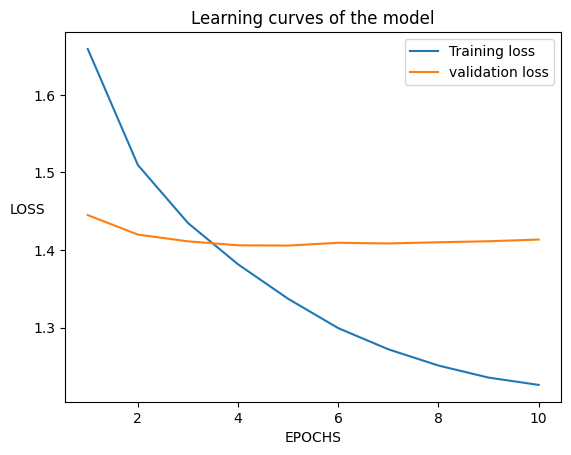

In [30]:
plt.plot(range(1,11),history.history['loss'],label="Training loss")
plt.plot(range(1,11),history.history['val_loss'],label="validation loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS",rotation=0)
plt.title("Learning curves of the model")
plt.legend()

In [ ]:
plt.plot(range(1,11),history.history['accuracy'],label="Training loss")
plt.plot(range(1,11),history.history['val_accuracy'],label="validation loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS",rotation=0)
plt.title("Learning curves of the model")
plt.legend()

In [31]:

#generating the summaries on the testing dataset
reference=[]
model_generated=[]
for batch in tqdm(tf_valid_dataset):
  labels=batch['labels'].numpy()
  labels=np.where(labels!=-100,labels,tokenizer.pad_token_id)
  labels=tokenizer.batch_decode(labels,skip_special_tokens=True)
  reference.extend(labels)
  pred=model.generate(**batch,min_length=55,max_length=100)
  pred_decoded = tokenizer.batch_decode(pred,skip_special_tokens=True)
  model_generated.extend(pred_decoded)


  0%|          | 0/83 [00:00<?, ?it/s]


InvalidArgumentError: Exception encountered when calling layer 'SelfAttention' (type TFT5Attention).

{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:AddV2] name: 

Call arguments received by layer 'SelfAttention' (type TFT5Attention):
  • hidden_states=tf.Tensor(shape=(8, 512, 768), dtype=float32)
  • mask=tf.Tensor(shape=(8, 1, 1, 512), dtype=float32)
  • key_value_states=None
  • position_bias=None
  • past_key_value=None
  • layer_head_mask=None
  • query_length=None
  • use_cache=False
  • training=False
  • output_attentions=False

In [32]:

def calc_metrics(preds,actual):
  metrics=['rouge1','rouge2','rougeL']
  result={metrics[0]:[],metrics[1]:[],metrics[2]:[]}
  for metric in metrics:
    precision=[]
    recall=[]
    f1=[]
    scorer = rouge_scorer.RougeScorer([metric],use_stemmer=True)
    for x,y in zip(model_generated,reference):
      scores = scorer.score(x,y)
      precision.append(scores[metric][0])
      recall.append(scores[metric][1])
      f1.append(scores[metric][2])
    result[metric].append(np.mean(precision))
    result[metric].append(np.mean(recall))
    result[metric].append(np.mean(f1))
  return pd.DataFrame(result,index=['Precision','Recall','F1-Score'])

In [33]:
scores=calc_metrics(model_generated,reference)
scores

,rouge1,rouge2,rougeL
Precision,NaN,NaN,NaN
Recall,NaN,NaN,NaN
F1-Score,NaN,NaN,NaN


In [34]:
#creating a function to generate summary
def generate_summary(text,min_length=55,max_length=80):
  text = "summarize: "+text
  input = tokenizer(text,max_length=512,truncation=True,return_tensors="tf").input_ids
  op=model.generate(input,min_length=min_length,max_length=max_length)
  decoded_op = tokenizer.batch_decode(op,skip_special_tokens=True)
  return decoded_op


# **Testing the model to summarize for some random news from the web**

In [36]:
text="""Scientists have discovered a new species of orchid in the tropical
forests of Colombia. The orchid, named Maxillaria anacatalina-portillae,
is distinguished by its unique yellow flowers with red spots. The discovery
highlights the rich biodiversity of the region and underscores the importance
of conservation efforts. According to the research team, this orchid species is
found at altitudes between 1,200 and 1,800 meters and blooms during the wet season.
However, habitat destruction due to deforestation poses a significant threat to its 
abs. Conservationists are calling for immediate measures to protect the area and its unique flora."""

actual_summary= """Scientists have identified a new orchid species, Maxillaria 
anacatalina-portillae, in Colombia's tropical forests. The orchid, notable for its
yellow flowers with red spots, faces threats from
deforestation, prompting calls for conservation efforts to protect its habitat."""

In [37]:
predicted_summary = generate_summary(text,min_length=20,max_length=128)

I0000 00:00:1733818045.646428     122 service.cc:145] XLA service 0x7832aa19da70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733818045.646480     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733818045.646490     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733818045.834309     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [38]:
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'],use_stemmer=True)
scorer.score(predicted_summary[0],actual_summary)

{'rouge1': Score(precision=0.5526315789473685, recall=0.42857142857142855, fmeasure=0.4827586206896552),
 'rouge2': Score(precision=0.2702702702702703, recall=0.20833333333333334, fmeasure=0.23529411764705882),
 'rougeL': Score(precision=0.42105263157894735, recall=0.32653061224489793, fmeasure=0.367816091954023)}

In [40]:
# testfile=os.path.join("/content/drive/MyDrive/Data/News/amazon news.txt")
# text = open(testfile,"r").read()
# print(text)
# print(len(text.split()))

In [41]:
predicted_summary = generate_summary(text,min_length=30,max_length=128)

In [42]:
predicted_summary

['Scientists have discovered a new species of orchid in the tropical forests of Colombia. The orchid, named Maxillaria anacatalina-portillae, is distinguished by its unique yellow flowers with red spots. The orchid blooms during the wet season and is found at altitudes between 1,200 and 1,800 meters.']

In [50]:
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
model = TFAutoModelForSeq2SeqLM.from_pretrained("model_directory")
tokenizer = AutoTokenizer.from_pretrained("model_directory")



All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at model_directory.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [44]:
import pickle
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Save the model using the Transformers library's method
model.save_pretrained("model_directory")  # This saves the model in Hugging Face's format
tokenizer.save_pretrained("model_directory")  # Saves the tokenizer alongside the model

# Save the training history object
with open("t5_history.pkl", 'wb') as f:
    pickle.dump(history.history, f)  # Save the training history

# If you want to save the tokenizer using pickle (though not necessary as it is already saved above)
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)  # Save the tokenizer (if needed)


In [46]:
import pickle
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Save the model
model.save_pretrained("model_directory")  # Save the model in Hugging Face's format
tokenizer.save_pretrained("model_directory")  # Save the tokenizer in Hugging Face's format

# Save the training history object
with open("t5_history.pkl", 'wb') as f:
    pickle.dump(history.history, f)  # Save the training history

# Save the tokenizer using pickle (optional, not recommended as it's already saved using Hugging Face method)
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)  # Save the tokenizer object
